<a href="https://colab.research.google.com/github/GeorgeB145/AT2_Image_Generation/blob/main/image_2_image_using_diffusers_for_season_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image2Image Pipeline for Stable Diffusion using 🧨 Diffusers

This notebook shows how to create a custom `diffusers` pipeline for  text-guided image-to-image generation with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).



In [ ]:
!nvidia-smi

Wed May  8 18:17:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install diffusers==0.3.0
!pip install scipy ftfy
!pip install transformers==4.24.0
!pip install "ipywidgets>=7,<8"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

You need to accept the model license before downloading or using the weights. In this post we'll use model version `v1-4`, so you'll need to  visit [its card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree.

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Image2Image pipeline.

In [ ]:
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

Load the pipeline

In [ ]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True
)
pipe = pipe.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

v1-variants-scores.jpg:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Download an initial image and preprocess it so we can pass it to the pipeline.

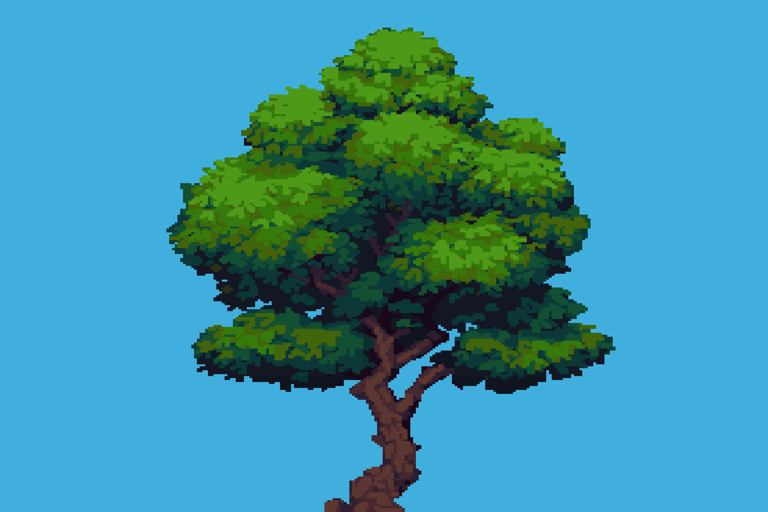

In [ ]:
import requests
from io import BytesIO
from PIL import Image

#The user will be able to copy any web link to an image online and paste it here

url = "https://preview.redd.it/background-tree-pixel-art-wip-v0-xekxe6htc9ta1.png?auto=webp&s=9636006422299ab0a79fcbb056660e1329d762e3"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((768, 512))
init_img

Define the prompt and run the pipeline.

In [ ]:
prompt = "An autumn tree, pixel art style, brown, fall"
# the user can type in specific prompts here

Here, `strength` is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 allow for lots of variations but will also produce images that are not semantically consistent with the input.

In [ ]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.6, guidance_scale=50, generator=generator).images[0]
    #Recommended strength >= 0.5, recommended guidance should range between 10 - 75

  0%|          | 0/31 [00:00<?, ?it/s]

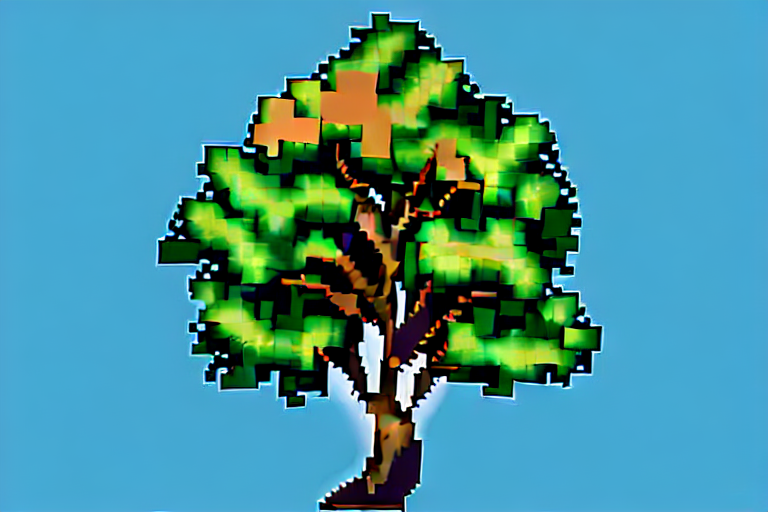

In [ ]:
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.5, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/26 [00:00<?, ?it/s]

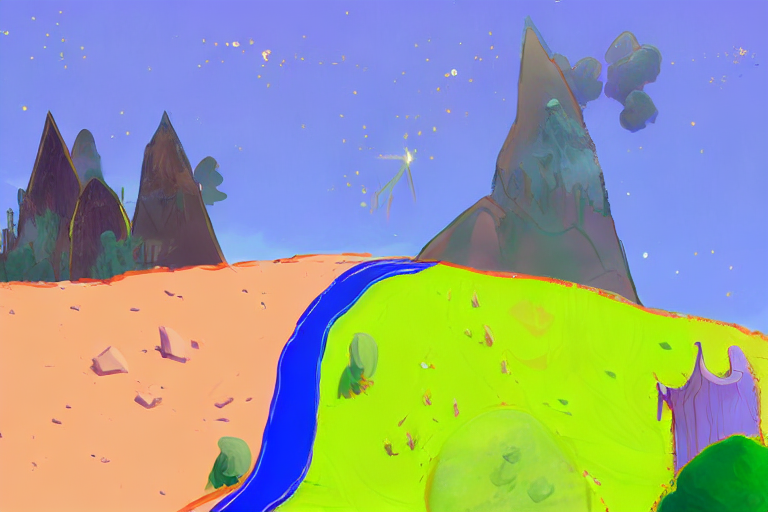

In [ ]:
image

As you can see, when using a lower value for `strength`, the generated image is more closer to the original `init_image`


Now using [LMSDiscreteScheduler](https://huggingface.co/docs/diffusers/api/schedulers#diffusers.LMSDiscreteScheduler)

In [ ]:
from diffusers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
pipe.scheduler = lms

In [ ]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.75, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/37 [00:00<?, ?it/s]

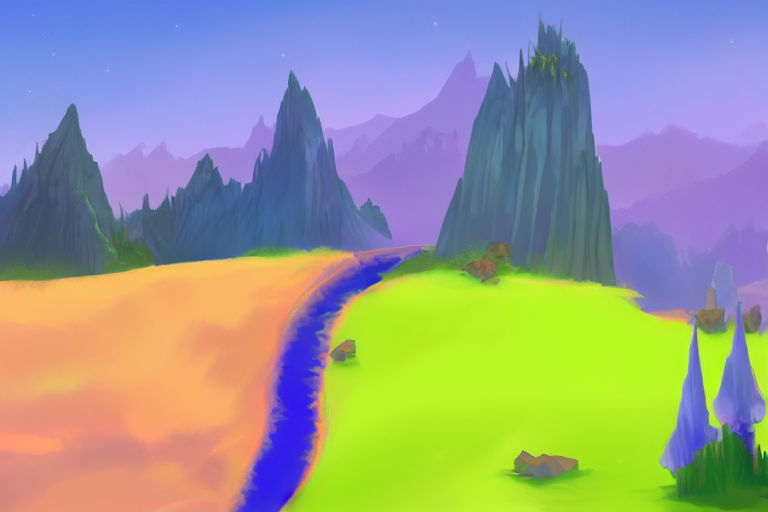

In [ ]:
image